In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

In [4]:
from qiskit_aer import Aer

from qiskit.circuit                               import QuantumCircuit
from qiskit.circuit.library                       import PauliEvolutionGate
from qiskit.visualization import *

from qiskit_nature.units                        import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

import qiskit_nature 
qiskit_nature.settings.use_pauli_sum_op = False 
from qiskit_nature.second_q.mappers               import ParityMapper

from qiskit_aer.primitives import Estimator

from scipy.optimize import minimize
from scipy import linalg
import random

## Hamiltonian Variational Ansatz 

As we have previously discussed in the overview of VQE, a key ingredient to the success of the variational quantum algorithm is finding a good parameterization scheme to approximate the wave function. For ground state simulation, the manifold of states parameterized by the ansatz of choice should contains/overlap with the ground state wavefunctin of interest, such that this ground state can be reached using a numerical optimization. The Hamiltonian Variational Ansatz (HVA) is a quantum circuit ansatz inspired by the quantum approximation optimization algorithm (QAOA) and adiabatic computation [1].

It has been shown that HVA exhibits favorable structural properties such as mild or entirely absent barren plateaus and a restricted state space that eases their optimization in comparison to the widely used “hardware-efficient" ansatz. [2]

Consider a family of Hamiltonians: 

$H = \sum_{k} c_k P_k$

where $P_k$ are some Pauli strings and $c_k$ are the corresponding coefficients. Instead of using only two (non-commuting) operators as in QAOA, HVA uses more terms of the Hamiltonian. Specifically, the HVA ansatz takes the form of:

$|\psi(\theta)\rangle = \prod_{l=1}^{L} \bigg( \prod_k \mbox{exp}[- i \theta_{k,l}P_k] \bigg) |\psi_0\rangle$

where $L$ is the number of layers, $\theta_{k,l}$ is the variational parameters. $|\psi_0\rangle$ is the initial state and its choice depends on the specific problem of interest. 


In [5]:
backend = Aer.get_backend('statevector_simulator')
N = 2        # number of qubits 
layers = 2   # number of layers in the ansatz

# Build the Hamiltonian ansatz 
def apply_ansatz(circuit, theta, hamiltonian):
    no_terms = len(hamiltonian)
    no_qubits = hamiltonian.num_qubits
    
    for l in range(0, layers):
        for i in range(0, no_terms):
            operator = hamiltonian[i]/hamiltonian[i].coeffs[0]
            evol = PauliEvolutionGate(operator, theta[i + no_terms*l])
            circuit.append(evol, range(no_qubits))

# Cost function, which is simply the expectation value of the Hamiltonian 
def cost_function(theta):    
    circuit = QuantumCircuit(N)
    for n in range(0, N):
        circuit.h(n)
    
    apply_ansatz(circuit, theta, hamiltonian)
    estimator = Estimator(run_options={"shots": None}, approximation=True)
    expectation_value = estimator.run(circuit, hamiltonian).result().values

    return expectation_value.real

## Example 1: The Ising spin model and Relation with QAOA

The Ising model is a paradigmatic model for studies of condensed matter physics. Additionally, many optimization problems can also be mapped onto an Ising Hamiltonian. For simplicity, we consider a 2-spin Ising system - its Hamiltonian is given by:

$H = -[ g\,\sigma^z_1 \sigma^z_2 + (\sigma^x_1 + \sigma^x_2)] $

where $g$ is the coupling coefficient. The HVA for such system is then simply of the form: 

$|\psi(\theta)\rangle = \mbox{exp}[- i \theta_{1}\sigma^x_1] \, \mbox{exp}[- i \theta_{2}\sigma^x_2] \, \mbox{exp}[- i \theta_{3}\sigma^z_1\sigma^z_2] |\psi_0\rangle $

which is structurally the same as the widely used QAOA. 

In [11]:
from qiskit.quantum_info import SparsePauliOp

# Define Ising Hamiltonian 
hamiltonian = SparsePauliOp.from_list([("XI", -1.0), ("IX", -1.0), ("ZZ", -0.5)])

# Minimize the cost function using optimizer of choice
out = minimize(cost_function, x0=[float(random.randint(-314, 314))/100 for i in range(0, layers*len(hamiltonian))], method="COBYLA", options={'maxiter':2000})

print("Optimized energy :", out.fun)

# Let's compare the results to exact diagonalization
print("Exact results :", linalg.eigvals(hamiltonian.to_matrix()).min().real)

Optimized energy : -2.0615527646095053
Exact results : -2.0615528128088307


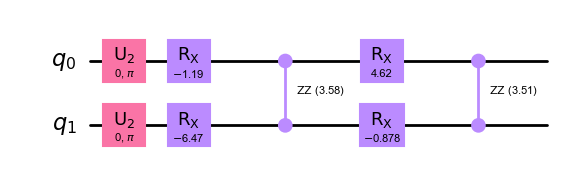

In [12]:
# Let's look at what the circuit looks like 
circuit = QuantumCircuit(N)

for n in range(0, N):
    circuit.h(n)

apply_ansatz(circuit, out.x, hamiltonian)
circuit.decompose().draw('mpl')

## Example 2: Hydrogen Molecule 
Here we demonstrate the calculation of the ground state energy of the hydrogen molecule $H_2$ at equilibrium bond distance of 0.735 Angstrom using the HVA. As we have seen in previous notebooks, the fermionic Hamiltonian of molecules can be mapped to qubits using various fermion-to-qubit transformations, in this example we will use the Parity Mapping. 

In [13]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Get Hamiltonian in second-quantized form
es_problem = driver.run()

# Transform the Hamiltonian to our qubit operator using Parity Mapping
mapper = ParityMapper(num_particles=es_problem.num_particles)

second_q_op = es_problem.hamiltonian.second_q_op()
hamiltonian = mapper.map(second_q_op)

print('H_2 Hamiltonian in qubit form:')
for pauli, coeff in sorted(hamiltonian.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

H_2 Hamiltonian in qubit form:
-1.05237325 * II
+0.39793742 * IZ
+0.18093120 * XX
-0.39793742 * ZI
-0.01128010 * ZZ


In [14]:
layers = 2
N = 2 # number of qubits 

# Modify the initial state such that it starts with <01> + |10>
def cost_function2(theta):
    
    circuit = QuantumCircuit(N)
    circuit.h(0) # Pauli-X gate 
    circuit.x(1) # Hadamard gate 
    circuit.cx(0, 1)
    
    apply_ansatz(circuit, theta, hamiltonian)
    estimator = Estimator(run_options={"shots": None}, approximation=True)
    expectation_value = estimator.run(circuit, hamiltonian).result().values[0]
    return expectation_value.real

In [15]:
# Minimize the cost function using optimizer of choice
out = minimize(cost_function2, x0=[float(random.randint(-314,314))/100 for i in range(0, layers*len(hamiltonian))], 
               method="COBYLA", options={'maxiter':2000})

print("Optimized energy :", out.fun)

# Let's compare the results to exact diagonalization
print("Exact results :", linalg.eigvals(hamiltonian.to_matrix()).min().real)

Optimized energy : -1.8572750301723586
Exact results : -1.8572750302023795


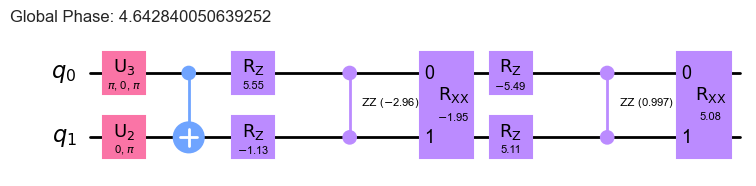

In [16]:
# Again let's take a look at what the circuit looks like 
circuit = QuantumCircuit(N)
circuit.x(0) # Pauli-X gate 
circuit.h(1) # Hadamard gate 
circuit.cx(0, 1)

apply_ansatz(circuit, out.x, hamiltonian)
circuit.decompose().draw('mpl')

## References
1) Dave Wecker, Matthew B. Hastings, and Matthias Troyer. Progress towards Practical Quantum Variational Algorithms. *Phys. Rev. A*, 92:042303, 2015.

2) Roeland Wiersema, Cunlu Zhou, Yvette de Sereville, Juan Felipe Carrasquilla, Yong Baek Kim, and Henry Yuen. Exploring Entanglement and Optimization within the Hamiltonian Variational Ansatz. *PRX Quantum* 1, 020319. 

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>
